# Titanic Analysis

### Initialize the Kaggle API 

In [5]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import zipfile

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

competition_name = "titanic"
download_path = os.getcwd()  # Folder where the dataset will be saved

# Download the competition files
api.competition_download_files(competition_name, path=download_path)

# # Path of downloaded ZIP file
zip_path = os.path.join(download_path, f"{competition_name}.zip")

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(download_path)
os.remove(zip_path)  # Remove the ZIP file after extraction


### Import library

We'll start by importing the necessary libraries and then configure the notebook to read the data into a DataFrame.

In [6]:
# import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import csv

### Data Acquisition

Loading the `train.csv` and `test.csv` bases for analysis. Let's take a first look at our Dataframe.

In [9]:
# Load the datasets
train = pd.read_csv('train.csv', sep=',')
test = pd.read_csv('test.csv', sep=',')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Dictionary/Variable Notes

[Titanic Data](https://github.com/maylonleoncio/titanic/blob/main/train.csv)  - Contains demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic.

<style>
  table {
    margin: auto;
    width: 50%;
    border-collapse: collapse; /* Para unir as bordas das células */
  }
  th, td {
    text-align: justify;
    padding: 8px;
    border: 1px solid black; /* Adiciona uma borda de 1px com cor cinza (#ddd) */
  }
</style>

<table>
    <tr>
        <th> Variable </th>
        <th> Definition </th>
        <th> Key </th> 
    </tr>
    <tr>
        <td>survival</td>
        <td>Survival</td>
        <td>0 = No, 1 = Yes</td>
    </tr>
    <tr>		
        <td>Pclass</td>
        <td>Ticket class</td>
        <td>1 = 1st, 2 = 2nd, 3 = 3rd</td>
    </tr>
    <tr>		
        <td>sex</td>
        <td>Sex</td>
        <td></td>
    </tr>
    <tr>		
        <td>Age</td>
        <td>Age in years</td>
        <td></td>
    </tr>
    <tr>		
        <td>sibsp</td>
        <td># of siblings / spouses aboard the Titanic</td>
        <td></td>
    </tr>
    <tr>		
        <td>parch</td>
        <td># of parents / children aboard the Titanic</td>
        <td></td>
    </tr>
    <tr>		
        <td>ticket</td>
        <td>Ticket number</td>
        <td></td>
    </tr>
    <tr>		
        <td>fare</td>
        <td>Passenger fare</td>
        <td></td>
    </tr>
    <tr>		
        <td>cabin</td>
        <td>Cabin number</td>
        <td></td>
    </tr>
    <tr>		
        <td>embarked</td>
        <td>Port of Embarkation</td>
        <td>C = Cherbourg, Q = Queenstown, S = Southampton</td>
    </tr>


</table>

**Pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**Age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**Sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

### Data cleaning

Before we begin the exploratory data analysis, we will perform a thorough cleaning of the database. **Data cleaning** is a crucial step in data analysis as it involves the __identification and removal of any missing, duplicated, or irrelevant data__. The goal is to ensure that the data is accurate, consistent, and error-free, as incorrect or inconsistent data can negatively impact the performance of Machine Learning models

In [10]:
# Check the data information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We observe that there are missing values at the Age, Cabin and Embarked columns.

In [11]:
cat_col = []
num_col = []

for col in train.columns:
    if train[col].dtype == 'object':
        cat_col.append(col)
    else:
        num_col.append(col)
print('Check the Categorical and Numerical Columns:')
print('Categorical columns: ', cat_col)
print('Numerical columns: ', num_col)

Check the Categorical and Numerical Columns:
Categorical columns:  ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Numerical columns:  ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [12]:
# Check the duplicate rows
train.duplicated().value_counts()

False    891
Name: count, dtype: int64

Note that there is no duplication of lines at the base.

In [13]:
print('Checking the total row count, the quantity of unique values, the number of nulls, and the percentage of nulls in each column.')
print()

print(pd.DataFrame({'Counts': train.count(), 'Counts unique': train.nunique(),'Counts NA': train.isnull().sum(),'Percentages (%) NA':  round(train.isnull().sum()/train.shape[0]*100,2)}))

Checking the total row count, the quantity of unique values, the number of nulls, and the percentage of nulls in each column.

             Counts  Counts unique  Counts NA  Percentages (%) NA
PassengerId     891            891          0                0.00
Survived        891              2          0                0.00
Pclass          891              3          0                0.00
Name            891            891          0                0.00
Sex             891              2          0                0.00
Age             714             88        177               19.87
SibSp           891              7          0                0.00
Parch           891              7          0                0.00
Ticket          891            681          0                0.00
Fare            891            248          0                0.00
Cabin           204            147        687               77.10
Embarked        889              3          2                0.22


It is noted that there are missing values in three variables. The ``Age`` column has 177 rows (**19.87%** of the total) without information, the ``Cabin`` variable has 687 rows (**77.1%** of the total), indicating that more than half of the data is missing, and in the ``Embarked`` column, out of a total of 891 rows, only 2 (**0.22%** of the total) are without information. We will have to decide whether to omit these variables or impute them with some values when we model relationships based on ``Age`` or ``Cabin`` or ``Embarked``.

##### Removal of all unwanted observations
Includes deleting duplicate/redundant or irrelevant values from the dataset.

In [14]:
train['Ticket'].unique()[:100]

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012

In [8]:
# Removal of all unwanted observations
train = train.drop(columns=['Name', 'Ticket'])
test = test.drop(columns=['Name', 'Ticket'])
train.shape

(891, 10)

##### Processing of missing data

Imputing the missing values from past observations. As we can see from the previous result that Cabin has 77% null values and Age has 19.87% and Embarked has 0.22% of null values.
So, it’s not a good idea to fill 77% of null values. So, we will drop the Cabin column. Embarked column has only 0.22% of null values so, we drop the null values rows of Embarked column.

In [9]:
train = train.drop(columns='Cabin')
test = test.drop(columns='Cabin')
train.dropna(subset=['Embarked'], axis=0, inplace=True)
train.shape

(889, 9)

##### Imputing the missing values from observations.

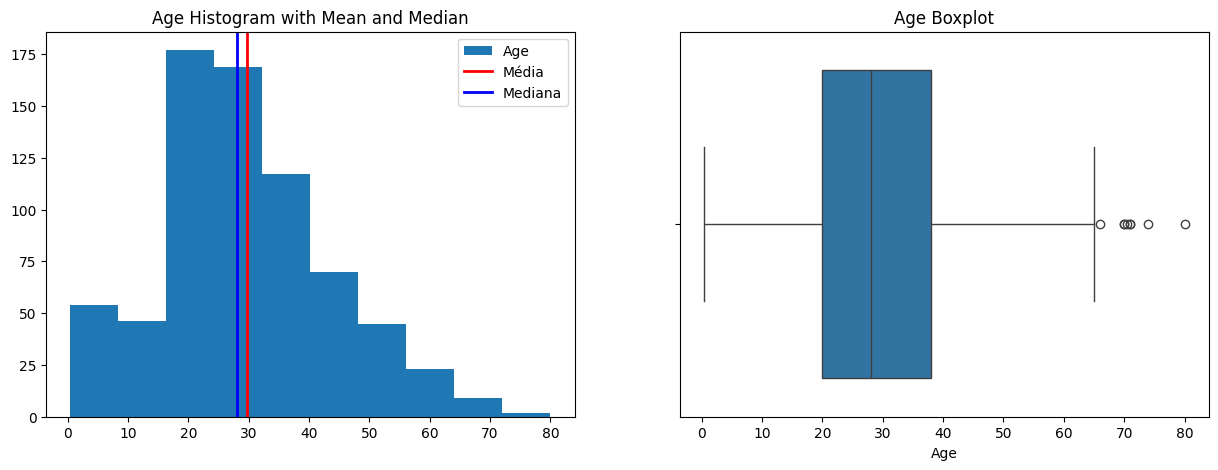

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Histograma da coluna 'Age'
ax[0].hist(x='Age', data=train)
ax[0].axvline(np.mean(train['Age']), color='red', linestyle='solid', linewidth=2, label='Média')
ax[0].axvline(np.median(train[train['Age'].notnull()]['Age']), color='blue', linestyle='solid', linewidth=2, label='Mediana')
ax[0].legend()
ax[0].set_title('Age Histogram with Mean and Median')

# Boxplot da coluna 'Age'
sns.boxplot(x="Age", data=train, ax=ax[1]).set_title('Age Boxplot')

plt.show()

<style>
  table {
    margin: auto;
    width: 50%;
    border-collapse: collapse; /* Para unir as bordas das células */
  }
  th, td {
    text-align: justify;
    padding: 8px;
    border: 1px solid black; /* Adiciona uma borda de 1px com cor cinza (#ddd) */
  }
</style>

<table>
    <tr>
        <th>  </th>
        <th> Age </th>
    </tr>
    <tr>
        <td>Population Size</td>
        <td>712.000</td>
    </tr>
    <tr>		
        <td>Mean</td>
        <td>29.642</td>
    </tr>
    <tr>		
        <td>Std. Deviation</td>
        <td>14.492</td>
    </tr>
    <tr>		
        <td>Min</td>
        <td>0.420</td>
    </tr>
    <tr>		
        <td>25% Qt</td>
        <td>20.000</td>
    </tr>
    <tr>		
        <td>Median</td>
        <td>28.000</td>
    </tr>
    <tr>		
        <td>75% Qt</td>
        <td>38.000</td>
    </tr>
    <tr>		
        <td>Max</td>
        <td>80.000</td>
    </tr>
</table>

Analyzing the graphs, the use of the **median** is preferable to replace missing age values, as it is a more robust measure in the presence of __outliers__.

In [11]:
# Median imputation
train = train.fillna(train[train['Age'].notnull()]['Age'].median())
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

### Exploratory Data Analysis (EDA) 

After initial data cleaning, we will delve deeper into our dataset to discover **patterns** and  __identify relationships between variables__.

Let's start by exploring the initial composition of passengers.

In [12]:
# Summary of the dataset
train.describe(include ='all')

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,889.000000,889.000000,889.000000,889,889.000000,889.000000,889.000000,889.000000,889
unique,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,male,NaN,NaN,NaN,NaN,S
freq,NaN,NaN,NaN,577,NaN,NaN,NaN,NaN,644
mean,446.000000,0.382452,2.311586,NaN,29.315152,0.524184,0.382452,32.096681,NaN
std,256.998173,0.486260,0.834700,NaN,12.984932,1.103705,0.806761,49.697504,NaN
min,1.000000,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN
25%,224.000000,0.000000,2.000000,NaN,22.000000,0.000000,0.000000,7.895800,NaN
50%,446.000000,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,14.454200,NaN
75%,668.000000,1.000000,3.000000,NaN,35.000000,1.000000,0.000000,31.000000,NaN


On the whole, in the Titanic profile, passengers had an average age of 29, the average ticket at the time was 32.09, and the average socioeconomic status (SES) was 2 (Middle)

##### Analysis of the Embarked variable

C:\Users\maylon\AppData\Local\Temp\ipykernel_6776\1721787117.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Embarked', data=train, palette='Set2')


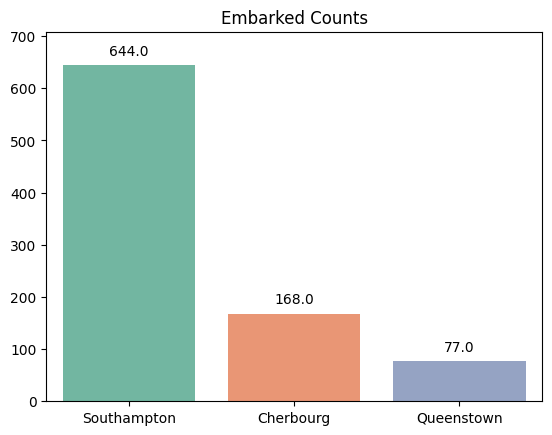

In [13]:
ax = sns.countplot(x='Embarked', data=train, palette='Set2')
ax.set_title('Embarked Counts')
plt.xticks([0, 1, 2], ['Southampton', 'Cherbourg', 'Queenstown'])
plt.xlabel('')
plt.ylabel('')
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylim(0, train['Embarked'].value_counts().max() * 1.1) 
#sns.despine()
plt.show()

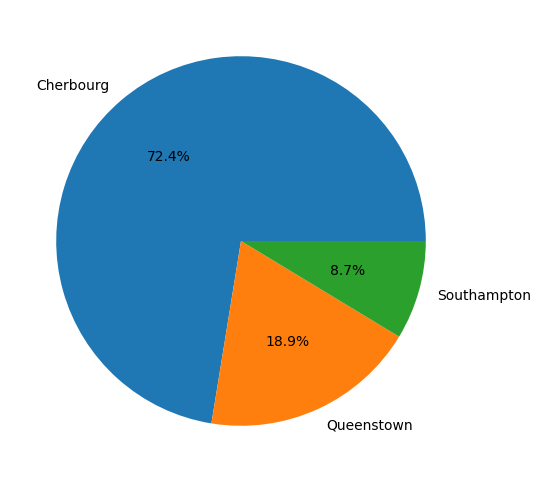

In [14]:
# Criar o gráfico de pizza
plt.figure(figsize=(10, 6))  # Ajusta o tamanho da figura
plt.pie(train['Embarked'].value_counts() / train.shape[0] * 100, labels=['Cherbourg', 'Queenstown', 'Southampton'], autopct='%1.1f%%')

plt.show()


In [15]:
train['faixa_age'] =  pd.cut(train['Age'], bins=[0, 18, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], right=False)

##### One hot encoded

In [16]:
train['Sex'] = train['Sex'].astype('category')
train['Embarked'] = train['Embarked'].astype('category')
train['faixa_age'] = train['faixa_age'].astype('category')
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  889 non-null    int64   
 1   Survived     889 non-null    int64   
 2   Pclass       889 non-null    int64   
 3   Sex          889 non-null    category
 4   Age          889 non-null    float64 
 5   SibSp        889 non-null    int64   
 6   Parch        889 non-null    int64   
 7   Fare         889 non-null    float64 
 8   Embarked     889 non-null    category
 9   faixa_age    889 non-null    category
dtypes: category(3), float64(2), int64(5)
memory usage: 58.8 KB


In [ ]:
# Não roda isso 
# Assigning numerical values and storing it in another columns 
train['Sex_new'] = train['Sex'].cat.codes 
train['faixa_age_new'] = train['faixa_age'].cat.codes 
  
# Create an instance of One-hot-encoder 
enc = OneHotEncoder() 
  
# Passing encoded columns 
enc_data = pd.DataFrame(enc.fit_transform(train[['Sex_new', 'faixa_age_new']]).toarray()) 

# Merge with main 
train = train.join(enc_data)

In [17]:
# LabelEncoder
train['Sex'] = train['Sex'].astype('category')
train['faixa_age'] = train['faixa_age'].astype('category')
# PARA CRIAR UMA NOVA COLUNA SEXO 
label_encoder = LabelEncoder()
train['Sex_binario'] = label_encoder.fit_transform(train['Sex'])
train['Embarked'] = label_encoder.fit_transform(train['Embarked'])
train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,faixa_age,Sex_binario
0,1,0,3,male,22.0,1,0,7.2500,2,3,1
1,2,1,1,female,38.0,1,0,71.2833,0,4,0
2,3,1,3,female,26.0,0,0,7.9250,2,3,0
3,4,1,1,female,35.0,1,0,53.1000,2,4,0
4,5,0,3,male,35.0,0,0,8.0500,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,2,3,1
887,888,1,1,female,19.0,0,0,30.0000,2,2,0
888,889,0,3,female,28.0,1,2,23.4500,2,3,0
889,890,1,1,male,26.0,0,0,30.0000,0,3,1


In [ ]:
train.iloc[:, :13]

In [18]:
train['faixa_age_new'].unique()

KeyError: 'faixa_age_new'

In [ ]:
test = test.fillna(test['Age'].mean())
one_hot_encoded_data_test = pd.get_dummies(test, columns = ['Sex'], dtype='int') 
one_hot_encoded_data_test['faixa_age'] =  pd.cut(test['Age'], bins=[0, 18, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], right=False)
one_hot_encoded_data_test

In [ ]:
one_hot_encoded_data_test = one_hot_encoded_data_test[['Sex_female', 'Sex_male', 'Pclass', 'Age', 'faixa_age', 'Fare']]
one_hot_encoded_data_test

In [ ]:
one_hot_encoded_data_test.isnull().sum()

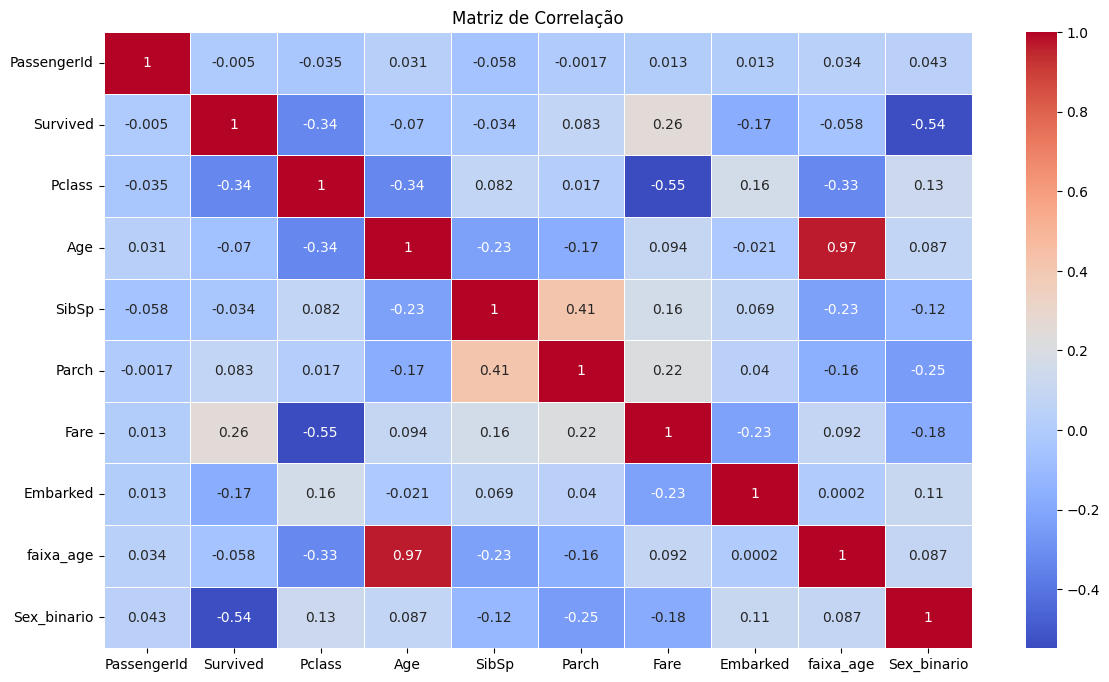

In [20]:
matrix_corr = train.drop(columns=['Sex']).corr()

plt.figure(figsize=(14, 8))
sns.heatmap(matrix_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  889 non-null    int64   
 1   Survived     889 non-null    int64   
 2   Pclass       889 non-null    int64   
 3   Sex          889 non-null    category
 4   Age          889 non-null    float64 
 5   SibSp        889 non-null    int64   
 6   Parch        889 non-null    int64   
 7   Fare         889 non-null    float64 
 8   Embarked     889 non-null    int32   
 9   faixa_age    889 non-null    category
 10  Sex_binario  889 non-null    int32   
dtypes: category(2), float64(2), int32(2), int64(5)
memory usage: 64.7 KB


In [22]:
X = train[['Pclass', 'Sex_binario',  'Age', 'Fare', 'Embarked']]
y = train.Survived

#### Modelando 

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5, random_state=1) # 0.5 é usado pq o dataset é muito pequeno 

In [24]:
mod = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
mod.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [25]:
X_prev = mod.predict(X_valid)
X_prev, X_prev.shape

(array([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 

In [26]:
np.mean(y_valid == X_prev)

0.797752808988764

In [48]:
np.mean(resultados)

0.8010076930863448

In [47]:
# METODO DE REAMOSTRAM 
# RepeatedKFold
resultados = []

kf = RepeatedKFold(n_splits=2, n_repeats=10, random_state=1)
for line_train, line_valid in kf.split(X):
    print('Treino: ', line_train.shape[0])
    print('Valid: ', line_valid.shape[0])

    X_train, X_valid = X.iloc[line_train], X.iloc[line_valid]
    y_train, y_valid = y.iloc[line_train], y.iloc[line_valid]


    mod = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
    #mod = LogisticRegression()
    mod.fit(X_train, y_train)


    X_prev = mod.predict(X_valid)
    acc = np.mean(y_valid == X_prev)
    resultados.append(acc)
    print('Acc:', acc)
    print()

Treino:  444
Valid:  445
Acc: 0.802247191011236

Treino:  445
Valid:  444
Acc: 0.7972972972972973

Treino:  444
Valid:  445
Acc: 0.8292134831460675

Treino:  445
Valid:  444
Acc: 0.7905405405405406

Treino:  444
Valid:  445
Acc: 0.7910112359550562

Treino:  445
Valid:  444
Acc: 0.8063063063063063

Treino:  444
Valid:  445
Acc: 0.8134831460674158

Treino:  445
Valid:  444
Acc: 0.7882882882882883

Treino:  444
Valid:  445
Acc: 0.8314606741573034

Treino:  445
Valid:  444
Acc: 0.8018018018018018

Treino:  444
Valid:  445
Acc: 0.7842696629213484

Treino:  445
Valid:  444
Acc: 0.8040540540540541

Treino:  444
Valid:  445
Acc: 0.8179775280898877

Treino:  445
Valid:  444
Acc: 0.777027027027027

Treino:  444
Valid:  445
Acc: 0.797752808988764

Treino:  445
Valid:  444
Acc: 0.7905405405405406

Treino:  444
Valid:  445
Acc: 0.7820224719101123

Treino:  445
Valid:  444
Acc: 0.7995495495495496

Treino:  444
Valid:  445
Acc: 0.802247191011236

Treino:  445
Valid:  444
Acc: 0.8130630630630631



In [38]:
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\maylon\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['mod']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


(array([2., 1., 4., 2., 5., 1., 2., 1., 0., 2.]),
 array([0.77702703, 0.78247039, 0.78791376, 0.79335712, 0.79880049,
        0.80424385, 0.80968722, 0.81513058, 0.82057394, 0.82601731,
        0.83146067]),
 <BarContainer object of 10 artists>)

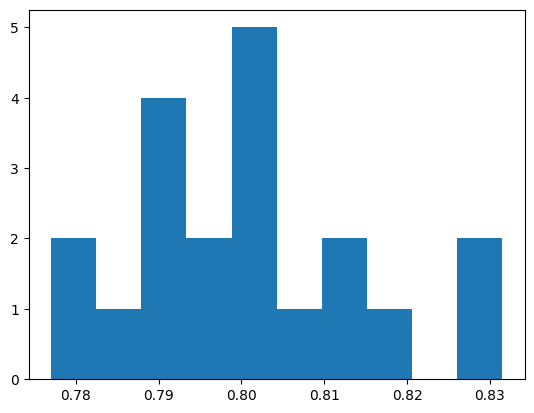

In [49]:
pylab.hist(resultados)

In [28]:
## Analise de Erro
X_valid_check = train.iloc[line_valid].copy()
X_valid_check['X_prev'] = X_prev
X_valid_check.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,faixa_age,Sex_binario,X_prev
0,1,0,3,male,22.0,1,0,7.2500,2,3,1,0
2,3,1,3,female,26.0,0,0,7.9250,2,3,0,0
3,4,1,1,female,35.0,1,0,53.1000,2,4,0,1
5,6,0,3,male,28.0,0,0,8.4583,1,3,1,0
6,7,0,1,male,54.0,0,0,51.8625,2,6,1,0


In [29]:
X_valid_check.shape

(444, 12)

In [34]:
erros = X_valid_check[X_valid_check['Survived'] != X_valid_check['X_prev']]
erros = erros[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'faixa_age', 'Sex_binario', 'Survived', 'X_prev']] # so ordenou para que as colunas Survived e X_orev fiquem lado a lado
erros.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,faixa_age,Sex_binario,Survived,X_prev
2,3,3,female,26.0,0,0,7.925,2,3,0,1,0
7,8,3,male,2.0,3,1,21.075,2,1,1,0,1
12,13,3,male,20.0,0,0,8.050,2,3,1,0,1
17,18,2,male,28.0,0,0,13.000,2,3,1,1,0
19,20,3,female,28.0,0,0,7.225,0,3,0,1,0


In [35]:
# Agora é a parte subjetiva, é a parte que voce usa o conhecimento dos dados, do processo que gerou esses dados, o conhecimento de machine learning para tentar melhorar esse modelo 

mulheres = erros[erros['Sex_binario'] == 0]
homens = erros[erros['Sex_binario'] == 1]

In [36]:
mulheres.sort_values('Survived')

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,faixa_age,Sex_binario,Survived,X_prev
882,883,3,female,22.0,0,0,10.5167,2,3,0,0,1
854,855,2,female,44.0,1,0,26.0000,2,5,0,0,1
816,817,3,female,23.0,0,0,7.9250,2,3,0,0,1
177,178,1,female,50.0,0,0,28.7125,0,6,0,0,1
680,681,3,female,28.0,0,0,8.1375,1,3,0,0,1
264,265,3,female,28.0,0,0,7.7500,1,3,0,0,1
297,298,1,female,2.0,1,2,151.5500,2,1,0,0,1
657,658,3,female,32.0,1,1,15.5000,1,4,0,0,1
357,358,2,female,38.0,0,0,13.0000,2,4,0,0,1
501,502,3,female,21.0,0,0,7.7500,1,3,0,0,1


In [37]:
homens.sort_values('Survived')

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,faixa_age,Sex_binario,Survived,X_prev
7,8,3,male,2.0,3,1,21.0750,2,1,1,0,1
667,668,3,male,28.0,0,0,7.7750,2,3,1,0,1
382,383,3,male,32.0,0,0,7.9250,2,4,1,0,1
378,379,3,male,20.0,0,0,4.0125,0,3,1,0,1
372,373,3,male,19.0,0,0,8.0500,2,2,1,0,1
351,352,1,male,28.0,0,0,35.0000,2,3,1,0,1
574,575,3,male,16.0,0,0,8.0500,2,1,1,0,1
711,712,1,male,28.0,0,0,26.5500,2,3,1,0,1
748,749,1,male,19.0,1,0,53.1000,2,2,1,0,1
722,723,2,male,34.0,0,0,13.0000,2,4,1,0,1


In [ ]:
# metodo de reamostragem
# validação cruzada 

resultados = []
for i in range(10):
    print('Rep:', i)
    kf = KFold(2, shuffle=True, random_state=i)
    for line_train, line_valid in kf.split(X):
        print('Treino: ', line_train.shape[0])
        print('Valid: ', line_valid.shape[0])

        X_train, X_valid = X.iloc[line_train], X.iloc[line_valid]
        y_train, y_valid = y.iloc[line_train], y.iloc[line_valid]


        mod = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
        mod.fit(X_train, y_train)


        X_prev = mod.predict(X_valid)
        acc = np.mean(y_valid == X_prev)
        resultados.append(acc)
        print('Acc:', acc)
        print()

In [ ]:
resultados

In [45]:
np.mean(resultados)

0.7913379390626583

In [ ]:
with open('gender_submission1.csv', 'w', newline='') as prediction:
    fields = ['PassengerId', 'Survived']
    prediction_writer = csv.DictWriter(prediction, fieldnames=fields)
    prediction_writer.writeheader()
    for passenger_id, survived in pd.Series(X_prev, index=test['PassengerId']).items():
        prediction_writer.writerow({'PassengerId': passenger_id, 'Survived': survived})
